## Импорты

In [1]:
import os
import math
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## Утилиты: сигмоида и NLL

In [2]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    return 1.0 / (1.0 + torch.exp(-z))

def binary_nll_loss(probs: torch.Tensor, targets: torch.Tensor, eps: float = 1e-12) -> float:
    probs = torch.clamp(probs, eps, 1.0 - eps)
    loss = - (targets * torch.log(probs) + (1 - targets) * torch.log(1 - probs))
    return float(torch.mean(loss).item())

## Классический (batch) градиентный спуск

In [ ]:
def train_one_neuron_batch(
    features: List[List[float]],
    labels: List[int],
    initial_weights: List[float],
    initial_bias: float,
    learning_rate: float,
    epochs: int,
) -> Tuple[List[float], float, List[float]]:
    # convert to tensors
    X = torch.tensor(np.array(features, dtype=np.float32))  # shape (N, D)
    y = torch.tensor(np.array(labels, dtype=np.float32))    # shape (N,)

    N, D = X.shape
    w = torch.tensor(np.array(initial_weights, dtype=np.float32))  # (D,)
    b = float(initial_bias)

    nll_history = []

    for epoch in range(epochs):
        # forward
        z = X.matmul(w) + b  # (N,)
        p = sigmoid(z)

        loss = binary_nll_loss(p, y)

        # gradients (vectorized)
        dz = (p - y)  # (N,)
        dw = X.t().matmul(dz) / N  # (D,)
        db = torch.mean(dz)

        # convert dw, db to float tensors
        w = w - learning_rate * dw
        b = b - learning_rate * float(db)

        nll_history.append(round(loss, 4))

    return w.numpy().tolist(), float(b), nll_history

## Stochastic Gradient Descent (SGD)

In [4]:
def train_one_neuron_sgd(
    features: List[List[float]],
    labels: List[int],
    initial_weights: List[float],
    initial_bias: float,
    learning_rate: float,
    epochs: int,
    shuffle: bool = True,
) -> Tuple[List[float], float, List[float]]:
    X = torch.tensor(np.array(features, dtype=np.float32))
    y = torch.tensor(np.array(labels, dtype=np.float32))

    N, D = X.shape
    w = torch.tensor(np.array(initial_weights, dtype=np.float32))
    b = float(initial_bias)

    nll_history = []

    for epoch in range(epochs):
        indices = np.arange(N)
        if shuffle:
            np.random.shuffle(indices)

        for i in indices:
            xi = X[i]  # (D,)
            yi = y[i]  # scalar

            zi = float(xi.dot(w) + b)
            pi = 1.0 / (1.0 + math.exp(-zi))

            # gradients for single example
            dz = pi - float(yi)  # scalar
            dw = dz * xi  # (D,)
            db = dz

            w = w - learning_rate * dw
            b = b - learning_rate * float(db)

        z = X.matmul(w) + b
        p = sigmoid(z)
        loss = binary_nll_loss(p, y)
        nll_history.append(round(loss, 4))

    return w.numpy().tolist(), float(b), nll_history

## Mini-batch Gradient Descent

In [5]:
def train_one_neuron_minibatch(
    features: List[List[float]],
    labels: List[int],
    initial_weights: List[float],
    initial_bias: float,
    learning_rate: float,
    epochs: int,
    batch_size: int = 32,
    shuffle: bool = True,
) -> Tuple[List[float], float, List[float]]:
    X = torch.tensor(np.array(features, dtype=np.float32))
    y = torch.tensor(np.array(labels, dtype=np.float32))

    N, D = X.shape
    w = torch.tensor(np.array(initial_weights, dtype=np.float32))
    b = float(initial_bias)

    nll_history = []

    for epoch in range(epochs):
        indices = np.arange(N)
        if shuffle:
            np.random.shuffle(indices)

        for start in range(0, N, batch_size):
            batch_idx = indices[start : start + batch_size]
            Xi = X[batch_idx]
            yi = y[batch_idx]
            n_batch = Xi.shape[0]

            zi = Xi.matmul(w) + b  # (batch,)
            pi = sigmoid(zi)

            dz = (pi - yi)  # (batch,)
            dw = Xi.t().matmul(dz) / n_batch
            db = torch.mean(dz)

            w = w - learning_rate * dw
            b = b - learning_rate * float(db)

        z = X.matmul(w) + b
        p = sigmoid(z)
        loss = binary_nll_loss(p, y)
        nll_history.append(round(loss, 4))

    return w.numpy().tolist(), float(b), nll_history

## Загрузка данных

In [ ]:
DATA_X = 'train_x.csv'
DATA_Y = 'train_y.csv'

if os.path.exists(DATA_X) and os.path.exists(DATA_Y):
    print('Найдены train_x.csv и train_y.csv')
    df_x = pd.read_csv(DATA_X)
    df_y = pd.read_csv(DATA_Y)
    id_col_x = df_x.columns[0]
    id_col_y = df_y.columns[0]
    df_x = df_x.rename(columns={id_col_x: 'id'})
    df_y = df_y.rename(columns={id_col_y: 'id'})

    if 'year' not in df_y.columns:
        other_cols = [c for c in df_y.columns if c != 'id']
        if len(other_cols) >= 1:
            df_y = df_y.rename(columns={other_cols[0]: 'year'})
        else:
            raise ValueError('Не удалось найти колонку с годом в train_y.csv')

    df = df_x.merge(df_y[['id', 'year']], on='id')
else:
    print('Файлы не найдены.')

Найдены train_x.csv и train_y.csv


In [8]:
df_x

,id,0,1,2,3,4,5,6,7,8,...,80,81,82,83,84,85,86,87,88,89
0,133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,...,104.03557,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682
1,111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,...,11.58664,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676
2,448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,...,23.61190,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276
3,254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,...,25.11398,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130
4,272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,...,-9.89388,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,235730,41.07421,-46.11382,-51.66532,0.37557,25.80398,1.26290,-10.49353,-10.07358,0.32333,...,31.83905,-72.36598,-54.92087,-24.15969,-17.09262,20.75098,-224.49090,-2.98255,-153.93735,-34.11660
13996,322111,34.81509,-13.13082,-29.35437,48.46882,-0.68983,-6.12095,-13.37087,4.50189,4.16561,...,14.70074,-319.94394,116.78836,41.62252,-4.45435,52.41625,100.77207,28.40019,8.61761,8.44485
13997,342863,39.71101,-57.06752,40.08736,-7.64027,30.32610,-15.75997,-6.22334,-3.18631,-6.17265,...,-14.39217,108.77959,59.58646,-7.72240,-3.35246,122.60833,-170.61831,-7.42530,-94.67988,0.41165
13998,64560,38.13518,-23.38279,-5.13088,18.32876,60.00752,-11.65138,24.97451,-8.92320,-31.83523,...,6.43782,257.93367,-33.29026,234.07660,9.55665,118.76462,-185.56438,3.25716,-3.88308,-33.33066


In [9]:
df_y

,id,year
0,133081,2001
1,111484,2006
2,448402,1989
3,254414,1997
4,272580,2001
...,...,...
13995,235730,1999
13996,322111,2008
13997,342863,1999
13998,64560,1993


## Подготовка бинарного поднабора
### выбираем два наиболее частых года

In [11]:
# распределение годов
print('\nРаспределение годов (топ-10):')
print(df['year'].value_counts().head(10))

# выбираем два самых частых года автоматически
top_years = df['year'].value_counts().index.tolist()[:2]
if len(top_years) < 2:
    raise ValueError('В данных меньше двух различных годов — нечего обучать бинарный классификатор')

year_a, year_b = top_years[0], top_years[1]
print(f"\nАвтоматически выбраны годы для бинарной задачи: {year_a} (метка=1) vs {year_b} (метка=0)")

# фильтруем строки, относящиеся только к этим двум годам
df_bin = df[df['year'].isin([year_a, year_b])].copy()
# создаем метки: 1 для year_a, 0 для year_b
df_bin['label'] = (df_bin['year'] == year_a).astype(int)

# признаки — все числовые колонки кроме id, year, label
feature_cols = [c for c in df_bin.columns if c not in ('id', 'year', 'label')]
X_all = df_bin[feature_cols].values.astype(float)
y_all = df_bin['label'].values.astype(int)

print(f"\nРазмер бинарного набора: {X_all.shape[0]} примеров, признаков: {X_all.shape[1]}")

# нормлизация для сходимости
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)


Распределение годов (топ-10):
year
2007    1102
2006    1031
2005    1001
2008     951
2009     835
2004     792
2003     703
2002     581
2001     580
2000     539
Name: count, dtype: int64

Автоматически выбраны годы для бинарной задачи: 2007 (метка=1) vs 2006 (метка=0)

Размер бинарного набора: 2133 примеров, признаков: 90


## Инициализация и запуск обучения (batch, sgd, minibatch)

In [ ]:
D = X_all.shape[1]
init_w = [0.0] * D
init_b = 0.0
lr = 0.1
epochs = 50

print('\nНачало обучения: Batch GD...')
w_batch, b_batch, loss_batch = train_one_neuron_batch(
    features=X_all.tolist(),
    labels=y_all.tolist(),
    initial_weights=init_w,
    initial_bias=init_b,
    learning_rate=lr,
    epochs=epochs,
)
print('Batch GD: Готово.')

print('Начало обучения: SGD...')
w_sgd, b_sgd, loss_sgd = train_one_neuron_sgd(
    features=X_all.tolist(),
    labels=y_all.tolist(),
    initial_weights=init_w,
    initial_bias=init_b,
    learning_rate=lr * 0.1,
    epochs=epochs,
)
print('SGD: Готово.')

print('Начало обучения: Mini-batch...')
w_mb, b_mb, loss_mb = train_one_neuron_minibatch(
    features=X_all.tolist(),
    labels=y_all.tolist(),
    initial_weights=init_w,
    initial_bias=init_b,
    learning_rate=lr,
    epochs=epochs,
    batch_size=32,
)
print('Mini-batch: Готово.')


Начало обучения: Batch GD...
Batch GD: Готово.
Начало обучения: SGD...
SGD: Готово.
Начало обучения: Mini-batch...
Mini-batch: Готово.


## Результаты и графики


Результаты обучения (последняя эпоха):
Batch GD: weights (first 5) = [-0.027199946343898773, -0.0030323551036417484, 0.017685770988464355, 0.006223216187208891, -0.06338663399219513], bias = 0.04830198227427901, final NLL = 0.6811
SGD:      weights (first 5) = [-0.1663253903388977, -0.0020307074300944805, -0.04562259092926979, 0.11105778068304062, -0.16536013782024384], bias = 0.05591610587286017, final NLL = 0.7358
Mini-B:  weights (first 5) = [-0.1363852620124817, 0.000795679516158998, -0.002016223967075348, 0.09877432882785797, -0.08194223791360855], bias = 0.05670838903170066, final NLL = 0.6883


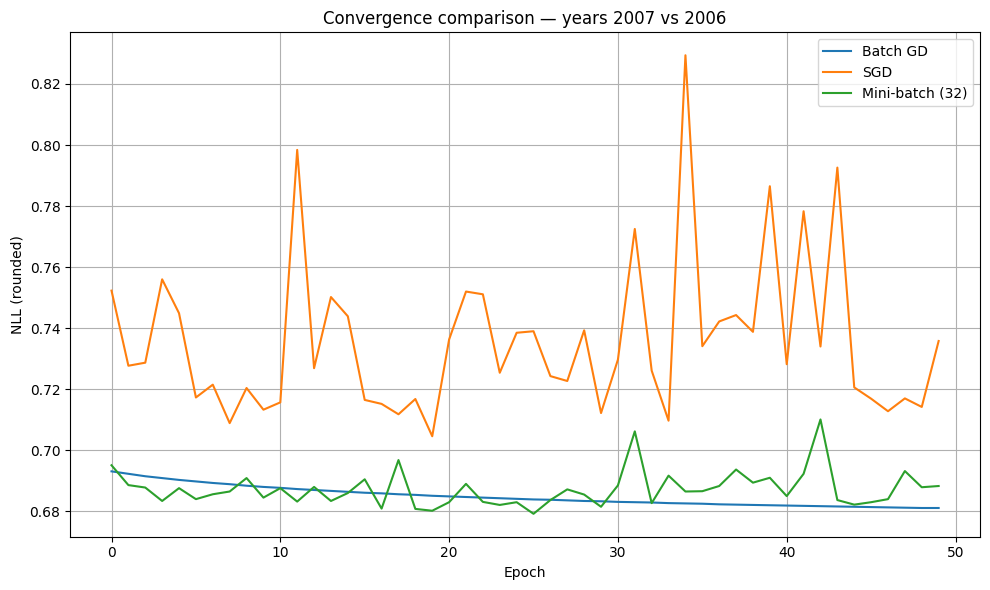

In [13]:
print('\nРезультаты обучения (последняя эпоха):')
print(f'Batch GD: weights (first 5) = {w_batch[:5]}, bias = {b_batch}, final NLL = {loss_batch[-1]}')
print(f'SGD:      weights (first 5) = {w_sgd[:5]}, bias = {b_sgd}, final NLL = {loss_sgd[-1]}')
print(f'Mini-B:  weights (first 5) = {w_mb[:5]}, bias = {b_mb}, final NLL = {loss_mb[-1]}')

# строим кривые сходимости
plt.figure(figsize=(10,6))
plt.plot(loss_batch, label='Batch GD')
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_mb, label='Mini-batch (32)')
plt.xlabel('Epoch')
plt.ylabel('NLL (rounded)')
plt.title(f'Convergence comparison — years {year_a} vs {year_b}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### попробуем уменьшить lr

In [14]:
print('Заново обучаем SGD...')
w_sgd, b_sgd, loss_sgd = train_one_neuron_sgd(
    features=X_all.tolist(),
    labels=y_all.tolist(),
    initial_weights=init_w,
    initial_bias=init_b,
    learning_rate=lr * 0.01,
    epochs=epochs,
)
print('SGD: Готово.')

Заново обучаем SGD...
SGD: Готово.


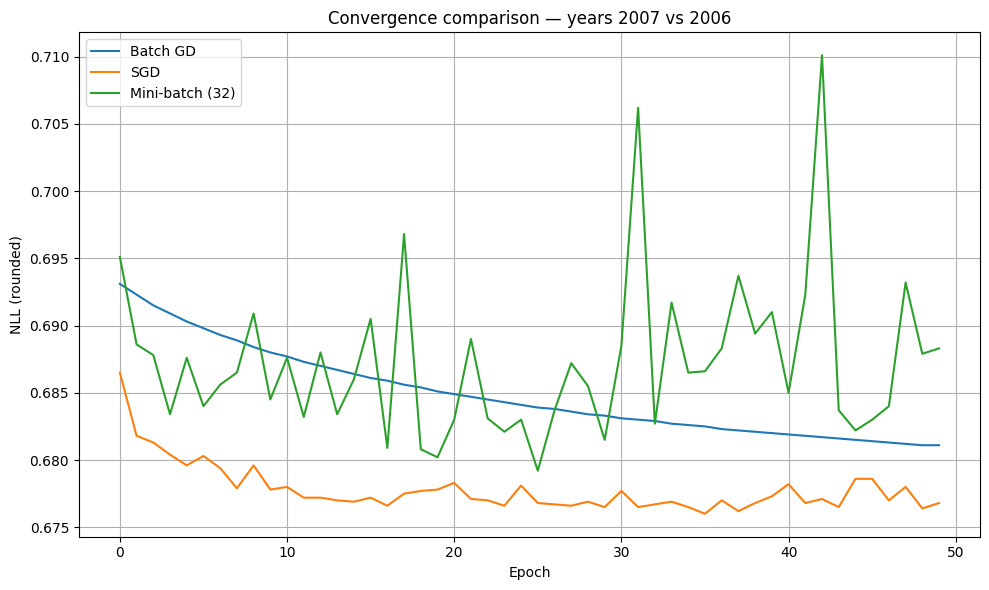

In [15]:
plt.figure(figsize=(10,6))
plt.plot(loss_batch, label='Batch GD')
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_mb, label='Mini-batch (32)')
plt.xlabel('Epoch')
plt.ylabel('NLL (rounded)')
plt.title(f'Convergence comparison — years {year_a} vs {year_b}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()